In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.8/654.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
2.20.0-dev20250310


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2025-03-11 15:20:02--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.07s   

2025-03-11 15:20:02 (5.19 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2025-03-11 15:20:02--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [3]:
train_data = pd.read_table(train_file_path, header=None, names=["spam", "message"])
train_data.head()

,spam,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [4]:
train_data.isnull().sum()

,0
spam,0
message,0


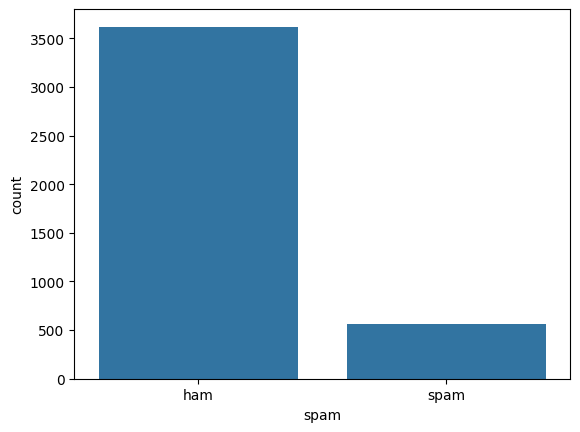

In [5]:
"""
for a better understanding, plot these counts

* the number of ham is much more than that of spam!
* the dataset is imbalanced...
"""
import seaborn as sns

sns.countplot(x='spam', data=train_data)
plt.show()

In [6]:
test_data = pd.read_table(test_file_path, header=None, names=["spam", "message"])
test_data.head()

,spam,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [7]:
test_data.isnull().sum()

,0
spam,0
message,0


In [8]:
train_data["spam"] = train_data["spam"].replace({"ham": 0, "spam": 1})
test_data["spam"] = test_data["spam"].replace({"ham": 0, "spam": 1})
train_data["spam"].value_counts()

<ipython-input-8-2b1baffe4a63>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data["spam"] = train_data["spam"].replace({"ham": 0, "spam": 1})
<ipython-input-8-2b1baffe4a63>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data["spam"] = test_data["spam"].replace({"ham": 0, "spam": 1})


,count
spam,
0,3619
1,560


In [9]:
"""
data bias could negatively affect learning
"""
# Downsampling to balance the dataset
ham_msg = train_data[train_data["spam"] == 0]
neg = ham_msg.shape[0]
print(f"negative: {neg}")

spam_msg = train_data[train_data["spam"] == 1]
pos = spam_msg.shape[0]
print(f"positive: {pos}")

total = neg + pos
print(f"total: {total}")

balanced_data = train_data

negative: 3619
positive: 560
total: 4179


In [10]:
"""
delete puctuations from texts
"""
import string
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['message'] = balanced_data['message'].apply(lambda x: remove_punctuations(x))

# Perform the same pre-processing on test data as on training data.
test_data['message'] = test_data['message'].apply(lambda x: remove_punctuations(x))

balanced_data.head()

,spam,message
0,0,ahhhhjust woken uphad a bad dream about u thos...
1,0,you can never do nothing
2,0,now u sound like manky scouse boy stevelike i ...
3,0,mum say we wan to go then go then she can shun...
4,0,never y lei i v lazy got wat dat day ü send me...


In [11]:
"""
delete stopwords from data
"""
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
new_stopwords = ["u", "ur"]
stop_words.extend(new_stopwords)

def remove_stopwords(text):
    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

balanced_data['message'] = balanced_data['message'].apply(lambda text: remove_stopwords(text))

# Perform the same pre-processing on test data as on training data.
test_data['message'] = test_data['message'].apply(lambda text: remove_stopwords(text))

balanced_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,spam,message
0,0,ahhhhjust woken uphad bad dream thoso dont lik...
1,0,never nothing
2,0,sound like manky scouse boy stevelike travelli...
3,0,mum say wan go go shun bian watch da glass exh...
4,0,never lei v lazy got wat dat day ü send da url...


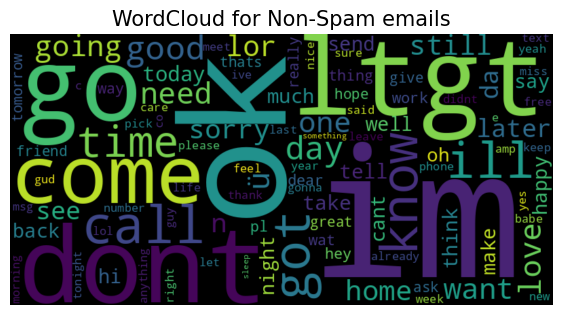

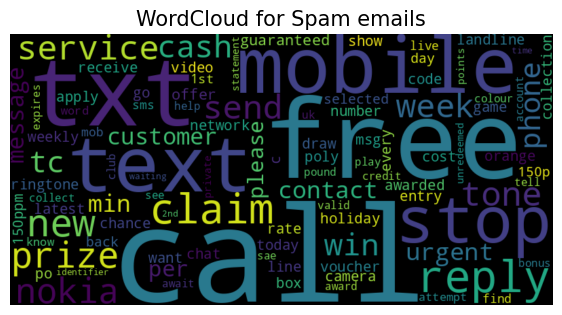

In [12]:
"""
visualize data by wordcloud

The results show that there are differences in the constituent words between spam and ham.
"""
from wordcloud import WordCloud
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['message'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(
        background_color='black',
        max_words=100,
        width=800,
        height=400,
        collocations=False
    ).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [13]:
"""
split label from data
"""
train_labels = balanced_data.pop("spam")
test_labels = test_data.pop("spam")

balanced_data

,message
0,ahhhhjust woken uphad bad dream thoso dont lik...
1,never nothing
2,sound like manky scouse boy stevelike travelli...
3,mum say wan go go shun bian watch da glass exh...
4,never lei v lazy got wat dat day ü send da url...
...,...
4174,woke yeesh late didnt fall asleep til ltgt
4175,reckon need 2 arrange transport cant thanks
4176,free entry £250 weekly competition text word w...
4177,pls stop bootydelious 32f inviting friend repl...


In [14]:
"""
convert dataframe to ndarray
"""
train_X = balanced_data["message"].to_numpy()
train_Y = train_labels.to_numpy()
test_X = test_data["message"].to_numpy()
test_Y = test_labels.to_numpy()
train_X

array(['ahhhhjust woken uphad bad dream thoso dont like right didnt know anything comedy night guess im',
       'never nothing',
       'sound like manky scouse boy stevelike travelling da bus homewot inmind 4 recreation dis eve',
       ...,
       'free entry £250 weekly competition text word win 80086 18 tc wwwtxttowincouk',
       'pls stop bootydelious 32f inviting friend reply yes434 no434 see wwwsmsacubootydelious stop send stop frnd 62468',
       'tell bad character dnt lik ill try change ltgt add tat 2 new year resolution waiting replybe frankgood morning'],
      dtype=object)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
# maximum sequence length
max_len = 100
train_sequences = pad_sequences(
    train_sequences,
    maxlen=max_len,
    padding='post',
    truncating='post'
)
test_sequences = pad_sequences(
    test_sequences,
    maxlen=max_len,
    padding='post',
    truncating='post'
)
print(train_sequences[0])

[3468 2262 3469  293  663 3470    7   12   76   94   11   86 1731   48
  203    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [16]:
"""
model development
"""
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=32,
        input_length=max_len,
        mask_zero=True,
    ),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
"""
model compile
"""
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
)

In [18]:
print(neg / total)

0.8659966499162479


In [19]:
"""
train the model
"""
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# callback
es = EarlyStopping(
    patience=4,
    monitor = 'val_accuracy',
    restore_best_weights = True
)

lr = ReduceLROnPlateau(
    patience = 2,
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1
)

# training weight
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

# Train the model
history = model.fit(
    x=train_sequences,
    y=train_Y,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks = [lr, es],
    class_weight=class_weight
)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.7421 - loss: 0.3580 - val_accuracy: 0.9665 - val_loss: 0.1497 - learning_rate: 0.0100
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.9974 - loss: 0.0296 - val_accuracy: 0.9593 - val_loss: 0.1633 - learning_rate: 0.0100
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9992 - loss: 0.0044 - val_accuracy: 0.9689 - val_loss: 0.1438 - learning_rate: 0.0100
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 1.0000 - loss: 5.7487e-04 - val_accuracy: 0.9689 - val_loss: 0.1631 - learning_rate: 0.0100
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 3.1527e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 1.0000 - loss: 3.1567e-04 - val_accuracy: 0.9713 - val_loss: 0.1689 - learning_rate: 0.0100
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 1.

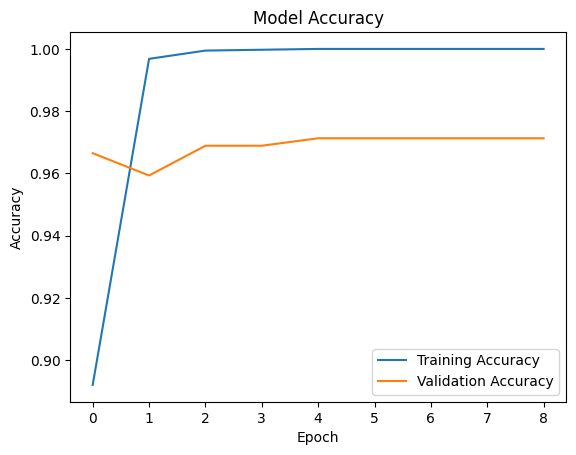

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9858 - loss: 0.0729
Test Loss : 0.06442448496818542
Test Accuracy : 0.9863505959510803


In [22]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
intTolabel = {0: "ham", 1: "spam"}

def predict_message(pred_text):
  pred_text = remove_punctuations(pred_text)
  pred_text = remove_stopwords(pred_text)

  sequence = tokenizer.texts_to_sequences([pred_text])
  sequence = pad_sequences(sequence, maxlen=max_len)

  prediction = model.predict(sequence)[0]

  label = "ham"
  if prediction >= 0.5:
      label = "spam"

  print((prediction[0], label))
  return (prediction[0], label)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
(0.0007917046, 'ham')


In [23]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(0.0007917046, 'ham')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(0.99796164, 'spam')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(3.989879e-05, 'ham')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(0.99975, 'spam')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
(0.99983335, 'spam')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(0.00032068905, 'ham')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(0.00010925304, 'ham')
You passed the challenge. Great job!
